In [ ]:
!unzip /content/DataDrivenAcceleration-XJ.zip -d /content/DataDrivenAcceleration-XJ
%cd /content/DataDrivenAcceleration-XJ

Archive:  /content/DataDrivenAcceleration-XJ.zip
  inflating: /content/DataDrivenAcceleration-XJ/.gitignore  
   creating: /content/DataDrivenAcceleration-XJ/.idea/
  inflating: /content/DataDrivenAcceleration-XJ/.idea/.gitignore  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/DataDrivenAcceleration.iml  
   creating: /content/DataDrivenAcceleration-XJ/.idea/inspectionProfiles/
  inflating: /content/DataDrivenAcceleration-XJ/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/misc.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/modules.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/vcs.xml  
   creating: /content/DataDrivenAcceleration-XJ/AADL/
  inflating: /content/DataDrivenAcceleration-XJ/AADL/__init__.py  
  inflating: /content/DataDrivenAcceleration-XJ/AADL/accelerate.py  
  inflating: /content/DataDrivenAcceleration-XJ/AADL/anderson_acceleration.py  
   creating: /content/DataDrivenAcceleration-XJ

In [ ]:
import time
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn 

from src.NN_models import *
from src.anderson_acceleration import *
from src.Phi import *
from src.utils import count_parameters

import AADL as AADL

## Problem Setup

Consider Burgers Equation

$$ u_t + u \cdot \nabla u - \Delta u = f         $$


Suppose we define $u$ as a function  composite of polynomials and expenential fucntions, i.e.

$$ u = e^{-t} (x_1 -1)(x_1 +1) \dots (x_n -1)(x_n + 1)$$

In [ ]:
def data_gen(x):
    # solution to burgers equation
    d = x.shape[1]
    xx = x[:,:d-1]
    xx = (xx-1) * (xx+1)
    sol = torch.prod(xx, dim=1).view(-1,1)
    sol = sol * torch.exp(-x[:,-1].view(-1,1))

    return sol

def forcing(x):
    # forcing term for the burgers equation
    d = x.shape[1]
    u = data_gen(x)
    ut = -u
    f = ut

    for i in range(d-1):
        ux_i = u / ((x[:,i]-1)*(x[:,i]+1)).view(-1,1)
        ux_i = 2*x[:,i].view(-1,1) * ux_i
        f = f + u * ux_i
    # laplacian 
    for i in range(d-1):
        uxx_i = 2 * u / ((x[:,i]-1)*(x[:,i]+1)).view(-1,1)
        f = f - uxx_i

    return f


In [ ]:
# define a test problem
def loss_burgers(x, y, x_to_train_f, d, net):
    '''
    :param x: input for boundary condition
    :param y: boundary data
    :param x_to_train_f: input for calculating PDE loss
    :param d: number of dimension
    :param net: network
    :return:  loss
    '''

    ### u_t + u*u_x1 + u^2*u_x2 + ... + u^d*u_xd = 0 with boundary and initial condition
    loss_fun = nn.MSELoss() 
    loss_BC = loss_fun(net.forward(x), y)

    g = x_to_train_f.clone()
    g.requires_grad = True
    
    u = net.forward(g)
    # gradient
    u_x_t = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(g.device), retain_graph=True, create_graph=True)[0]

    u_t = u_x_t[:,[-1]]; f = u_t
    for i in range(d-1):
        # iterate for space states
        f = f + u * u_x_t[:, [i]]

    # laplacian? depending on the problem
    num = x_to_train_f.shape[0]
    lap = torch.zeros(num,1).to(g.device)
    for i in range(d-1):
        vec = torch.zeros_like(u_x_t)
        vec[:,i] = torch.ones(num)
        u_xx_i = autograd.grad(u_x_t, g, vec, create_graph=True)[0]
        u_xxi = u_xx_i[:, [i]]

        lap = lap + u_xxi

    f = f - lap

    ## forcing term
    ff = forcing(g)


    loss_PDE = loss_fun(f, ff)
    loss = loss_BC + loss_PDE
 

    res_PDE = f - ff
    res_BC = net.forward(x) - y
    res = torch.cat((res_PDE, res_BC), dim=0)
    res = torch.flatten(res)


    return res, loss





In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

# parameter list
niters = 2000
N_u = 400
N_f = 4000
lr = 0.02
print_freq = 100

d = 100
# net = Phi(nTh=4,d=d,m=32)
layers = np.array([d, 50, 50, 50, 1])
net = MLP(layers)
net.to(device)

optim = torch.optim.Adam(params=net.parameters(), lr=lr)
accelerate(optim, frequency = 10)

# data
x = 0.5 * torch.rand(N_u, d).to(device)
y = data_gen(x); y = y.to(device)
x_to_train_f = 0.5 * torch.rand(N_f, d).to(device)

# evaluation
x_val = 0.5 * torch.rand(N_u, d).to(device)
y_val = data_gen(x_val); y_val = y_val.to(device)
print('initial validation error: ', torch.mean(torch.abs(y_val - net(x_val))))

for itr in range(1, niters + 1):
    def closure():
        optim.zero_grad()
        res, loss = loss_burgers(x, y, x_to_train_f, d, net)
        loss.backward()
        return res, loss
    optim.step(closure)


    if itr % print_freq == 0:
        _, loss = closure() 
        print(("%06d    " + "%1.4e    ") %(itr, loss))

    # resample
    if itr % 500 == 0:
        x = 0.5 * torch.rand(N_u, d).to(device)
        y = data_gen(x); y = y.to(device)
        x_to_train_f = 0.5 * torch.rand(N_f, d).to(device)
        clear_hist(optim)

    # change learning rate
    if itr % 1000 == 0:
        for p in optim.param_groups:
            p['lr'] *= 0.2


print('final validation error: ', torch.mean(torch.abs(y_val - net(x_val))))

## Averaging

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

# parameter list
N_u = 400
N_f = 4000
niters = 3000
lr = 0.02
print_freq = 100


d = 100

start_time = time.time() 
print((2 * "%7s    ") % ("step", "Loss"))
err_average = 0.

record = np.zeros([niters+1, 1])
for repeat in range(1):
    x = torch.cat((0.5*torch.randn(N_u, d-1), torch.rand(N_u, 1)), dim=1).to(device)   
    y = data_gen(x); y = y.to(device)
    x_to_train_f = torch.cat((0.5*torch.randn(N_f, d-1), torch.rand(N_f, 1)), dim=1).to(device)  

    x_val = torch.cat((0.5*torch.randn(500, d-1), torch.rand(500, 1)), dim=1).to(device)   
    y_val = data_gen(x_val); y_Val = y_val.to(device)

    layers = np.array([d, 50, 50, 50, 1])
    net = MLP(layers)
    net.to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    # accelerate(optim, frequency = 20)
    AADL.accelerate(optim, relaxation=1.0, store_each_nth=10, frequency=20)
    record[0,repeat] = loss_burgers(x, y, x_to_train_f, d, net)[1].detach()

    for itr in range(1, niters + 1):
        def closure():
            optim.zero_grad()
            res, loss = loss_burgers(x, y, x_to_train_f, d, net)
            loss.backward()
            return loss
        optim.step(closure)
        loss = loss_burgers(x, y, x_to_train_f, d, net)[1]
        record[itr, repeat] = loss.detach()

        if itr % print_freq == 0:
            print(("%06d    " + "%1.4e    ") %(itr, loss))

        # resample
        if itr % 500 == 0:
            x = torch.cat((0.5*torch.randn(N_u, d-1), torch.rand(N_u, 1)), dim=1).to(device)   
            y = data_gen(x); y = y.to(device)
            x_to_train_f = torch.cat((0.5*torch.randn(N_f, d-1), torch.rand(N_f, 1)), dim=1).to(device)   
            # clear_hist(optim)

        # change learning rate
        if itr % 2000 == 0:
            for p in optim.param_groups:
                p['lr'] *= 0.2

    # Validation
    err = torch.mean(torch.abs(y_val - net(x_val)))
    err_average += err
    print('Validation results, error in absolute value: ', err)

print('average validation error: ', err_average/1)
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

device:  cuda
   step       Loss    
000100    3.4704e-02    
000200    1.1745e-02    
000300    6.3146e-03    
000400    4.0520e-03    
000500    2.8511e-03    
000600    3.1222e-03    
000700    2.0081e-03    
000800    1.4481e-03    
000900    1.1094e-03    
001000    8.8358e-04    
001100    9.9002e-04    
001200    7.4105e-04    
001300    5.8648e-04    
001400    4.7994e-04    
001500    4.0194e-04    
001600    4.6985e-04    
001700    3.7589e-04    
001800    3.1247e-04    
001900    2.6593e-04    
002000    2.3006e-04    
002100    3.1823e-04    
002200    3.0035e-04    
002300    2.8485e-04    
002400    2.7079e-04    
002500    2.5778e-04    
002600    2.8380e-04    
002700    2.6661e-04    
002800    2.5168e-04    
002900    2.3812e-04    
003000    2.2559e-04    
Validation results, error in absolute value:  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
average validation error:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
Training time: 1800.21


In [ ]:
record0 = record

In [ ]:
record_accelerated = record

In [ ]:
record_AADL = record

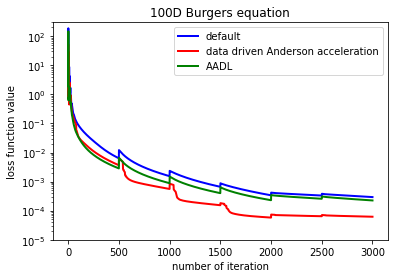

In [ ]:
import matplotlib.pyplot as plt

anderson_avg = np.mean(record_accelerated,axis=1)
anderson_std = np.std(record_accelerated,axis=1)
avg = np.mean(record0,axis=1)
std = np.std(record0,axis=1)

fig = plt.figure()
plt.plot(range(niters+1),avg, color='b', linewidth=2)
# plt.fill_between(range(niters+1), avg-std,avg+std,color='b',alpha=.2)
plt.plot(range(niters+1),anderson_avg, color='r', linewidth=2)
# plt.fill_between(range(niters+1), anderson_avg-anderson_std,anderson_avg+anderson_std,color='r',alpha=.2)

avg_AADL = np.mean(record_AADL,axis=1)
plt.plot(range(niters+1),avg_AADL, color='g', linewidth=2)


plt.yscale('log')
plt.ylim([1.e-5, 3.e2])
plt.legend(['default', 'data driven Anderson acceleration', 'AADL'])
plt.xlabel('number of iteration')
plt.ylabel('loss function value')
plt.title('100D Burgers equation')
fig.savefig('file.jpg', dpi=500)

In [ ]:
from google.colab import files
files.download('file.jpg') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>